In [1]:
import glob
import re
FILENAME_REGEX = '\.\/scraped\/statuses-([\d\-]+).json'
file_matches = [re.match(FILENAME_REGEX, file) for file in glob.glob("./scraped/statuses-*.json")]
files = [(m[1], m[0]) for m in file_matches]

In [2]:
import json
import time

def parse_date(date):
    if not date:
        return None
    
    date = date.replace("+", "")
    try:
        return time.strptime(date, "%m/%d/%Y")
    except:
        None
        
def release_dates_by_sid(file):
    sids = {}
    with open(file) as f:
        for line in f:
            l = json.loads(line)
            sids[l['sid']] = parse_date(l.get('earliest_release_date', None))
    return sids

In [3]:
dates = {}

for (date, file) in files:
    print(date)
    dates[date] = release_dates_by_sid(file)

2017-03-24
2017-03-30
2017-04-07
2017-04-14
2017-04-24
2017-05-02
2017-05-15
2017-05-22
2017-05-30


In [4]:
# Calculate the total number of data points we have for each SID.
# This doesn't calculate *unique* release dates, if a SID has the
#   same release date in all 9 scrapes then they will have 9
num_release_dates_by_sid = {}

for date, release_dates in dates.items():
    for sid, release_date in release_dates.items():
        num_release_dates_by_sid[sid] = num_release_dates_by_sid.get(sid, 0)

        if release_date is not None:
            num_release_dates_by_sid[sid] += 1

[(0, 1389), (1, 240), (2, 175), (3, 241), (4, 1942), (5, 1620), (6, 902), (7, 241), (8, 4683), (9, 2905)]


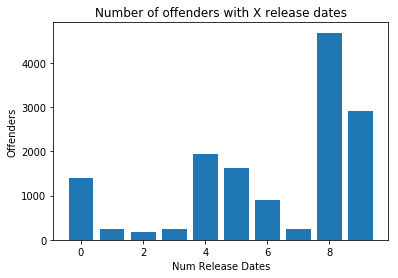

In [5]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

counts = [(sid, num) for sid, num in num_release_dates_by_sid.items()]
max_count = max(map(lambda i: i[1], counts))
num_per_count = [(c, len(list(filter(lambda v: v[1] == c, counts)))) for c in range(0, max_count + 1)]

# prints tuples like (N, C): C offenders have N parsable release dates
print(num_per_count)

x = list(map(lambda i: i[0], num_per_count))
y = list(map(lambda i: i[1], num_per_count))
plt.bar(x, y)
plt.title("Number of offenders with X (non-unique) release dates")
plt.xlabel("Num Release Dates")
plt.ylabel("Offenders")
plt.show()

In [142]:
def days_difference(time_one, time_two):
    """
    Returns a integral number of days difference (time_two - time_one).
    
    There must be a better way to do this but I can't google it now
    """
    return int((time.mktime(time_one) - time.mktime(time_two)) / 86400)
    
def date_changes(sid):
    last_release_date = None
    changes = []
    
    for date in dates.keys():
        release_date = dates[date].get(sid, None)
        if release_date:
            if not last_release_date:
                last_release_date = release_date
            else:
                if release_date != last_release_date:
                    change = (
                        date,
                        release_date,
                        days_difference(release_date, last_release_date),
                        days_difference(last_release_date, time.strptime(date, "%Y-%m-%d"))
                    )
                    changes.append(change)
                    last_release_date = release_date
    return changes

def print_changes(original, changes):
    original_formatted_time = time.strftime("%Y-%m-%d", original[1])
    print("On {} release date was: {}".format(original[0], original_formatted_time))
    for change in changes:
        date = change[0]
        release_date = change[1]
        days_different = change[2]
        days_to_gate = change[3]
        if not release_date:
            continue
        formatted_time = time.strftime("%Y-%m-%d", release_date)
        print("On {} release date became: {}".format(date, formatted_time))
        print("  ({} days, with {} days to-the-gate)".format(days_different, days_to_gate))

all_sids = set([])
changes_by_sid = {}
for v in dates.values():
    for sid in v:
        if sid not in all_sids:
            changes_by_sid[sid] = date_changes(sid)

        all_sids.add(sid)

In [143]:
# assume that *dates* is sorted by date, and take the first release
# date present
first_release_date_by_sid = {}
for date, release_dates in dates.items():
    for sid, release_date in release_dates.items():
        if sid in first_release_date_by_sid:
            continue
        if not release_date:
            continue
            
        first_release_date_by_sid[sid] = (date, release_date)

def egregiousness(changes):
    if not len(changes):
        return -2 # no changes? very un-egregious!
    change = changes[-1]
    days_different = change[2]
    days_to_gate = change[3]
    if days_different > 0:
        return -1 # delaying the release date? un-egregious!
    else:
        return -(days_different / days_to_gate)

change_tuples = list(filter(lambda el: egregiousness(el[1]) > 0.4,
    [(sid, changes) for sid, changes in changes_by_sid.items()]))
change_tuples.sort(key=lambda el: egregiousness(el[1]), reverse=True)

for (sid, changes) in change_tuples:
    if len(changes) > 1:
        print("SID: {} (egregiousness: {})".format(sid, round(egregiousness(changes), 2)))
        print_changes(first_release_date_by_sid[sid], changes_by_sid[sid])
        print("")

SID: 13373389 (egregiousness: 0.96)
On 2017-03-30 release date was: 2017-05-16
On 2017-05-22 release date became: 2017-08-14
  (90 days, with -6 days to-the-gate)
On 2017-05-30 release date became: 2017-06-02
  (-73 days, with 76 days to-the-gate)

SID: 18711820 (egregiousness: 0.92)
On 2017-03-24 release date was: 2017-05-17
On 2017-04-14 release date became: 2017-06-05
  (19 days, with 33 days to-the-gate)
On 2017-04-24 release date became: 2017-08-15
  (71 days, with 42 days to-the-gate)
On 2017-05-30 release date became: 2017-06-05
  (-71 days, with 77 days to-the-gate)

SID: 16643646 (egregiousness: 0.88)
On 2017-03-24 release date was: 2017-05-22
On 2017-05-02 release date became: 2017-08-18
  (88 days, with 20 days to-the-gate)
On 2017-05-30 release date became: 2017-06-09
  (-70 days, with 80 days to-the-gate)

SID: 11192942 (egregiousness: 0.81)
On 2017-03-24 release date was: 2017-07-06
On 2017-04-07 release date became: 2017-05-30
  (-37 days, with 90 days to-the-gate)
On 20